# Pre Processing

In [1]:
pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=c5fc08f8a513fa3fa4f5ea4cbd98ec12980e448dc3c2d95e1c3729c27c3865d0
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [2]:
!pip install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 9.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import anndata
import scipy as sp
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

MOSTA

In [4]:
sample=['1']
Batch_list = []
for i in np.arange(len(sample)):
    adata=sc.read_h5ad("/content/Dataset1_MERFISH.h5ad") # Reads File
    print(adata)
    adata.obs_names = [x + '_' + sample[i] for x in adata.obs_names] # Changes the index names
    sc.pp.normalize_total(adata, target_sum=1e4) # Normalizing
    sc.pp.log1p(adata) # log transformation
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000) # finds highly variable genes
    adata = adata[:, adata.var['highly_variable']] # Retains only highly variable
    Batch_list.append(adata) # Adds adata to batch list

AnnData object with n_obs × n_vars = 5488 × 155
    obsm: 'spatial'


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [5]:
Batch_list

[View of AnnData object with n_obs × n_vars = 5488 × 155
     var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'log1p', 'hvg'
     obsm: 'spatial']

In [6]:
adata

View of AnnData object with n_obs × n_vars = 5488 × 155
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [7]:
adata.obs_names

Index(['-3033x2825_1', '-3027x2956_1', '-3021x2962_1', '-3017x2996_1',
       '-3005x2878_1', '-3005x2898_1', '-3002x2965_1', '-2997x3005_1',
       '-2967x2894_1', '-2963x2927_1',
       ...
       '-1246x4188_1', '-1435x4295_1', '-1415x4415_1', '-1323x4411_1',
       '-1249x4418_1', '-1431x4324_1', '-1347x4422_1', '-1365x4412_1',
       '-1285x4407_1', '-1246x4494_1'],
      dtype='object', length=5488)

In [8]:
adata_concat = anndata.concat(Batch_list, label="slice_name", keys=sample)
vf=np.array(adata_concat.var.index)
for i in np.arange(len(sample)):
    adata1=adata_concat[adata_concat.obs['slice_name']==sample[i],:].copy()
    cells=adata1.obs_names
    # Convert adata1.X to a sparse matrix if it's not already
    if not isinstance(adata1.X, (sp.sparse.csr_matrix, sp.sparse.csc_matrix)):
        adata1.X = sp.sparse.csr_matrix(adata1.X)
    mat=pd.DataFrame(adata1.X.todense(),index=cells,columns=vf)
    coord=pd.DataFrame(adata1.obsm['spatial'],index=cells,columns=['x','y'])
    adata1.obs['annotation']= adata.obs_names
    meta=adata1.obs[['annotation','slice_name']]
    meta.columns=['celltype','batch']
    meta.index=cells
    mat.to_csv("/"+sample[i]+"_mat.csv") # creates mat.csv
    meta.to_csv("/"+sample[i]+"_meta.csv") # creates meta.csv
    coord.to_csv("/"+sample[i]+"_coord.csv") # creates coord.csv

In [9]:
"""dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_name=[151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676]
IDX=np.arange(0,12)
VF=[]
MAT=[]
flags=str(sample_name[IDX[0]])
for i in np.arange(1,len(IDX)):
    flags=flags+'-'+str(sample_name[IDX[i]])
flags=flags+"_"
for k in np.arange(len(IDX)):
    adata = sc.read_visium(path=dirs+"scanpy_file/"+str(sample_name[IDX[k]])+"/",
                       count_file="filtered_feature_bc_matrix.h5")
    adata.var_names_make_unique()
    Ann_df=pd.read_csv(dirs+"input/"+str(sample_name[IDX[k]])+"_label.txt", sep=',', header=0, index_col=0)
    Ann_df.columns=['Ground Truth','Sample']
    Ann_df.index=[i.split('-')[1]+'-'+i.split('-')[2] for i in Ann_df.index]
    adata=adata[Ann_df.index,:]
    adata.obs['Ground Truth']=Ann_df.loc[:,'Ground Truth']
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.obs['batch']=str(sample_name[IDX[k]])
    cells=[str(sample_name[IDX[k]])+'-'+i for i in adata.obs_names]
    mat1=pd.DataFrame(adata.X.toarray(),columns=adata.var_names,index=cells)
    coord1=pd.DataFrame(adata.obsm['spatial'],columns=['x','y'],index=cells)
    meta1=adata.obs[['Ground Truth', 'batch']]
    meta1.columns=['celltype','batch']
    meta1.index=cells
    meta1.to_csv(dirs+"gtt_input_scanpy/"+flags+str(sample_name[IDX[k]])+"_label-1.txt")
    coord1.to_csv(dirs+"gtt_input_scanpy/"+flags+str(sample_name[IDX[k]])+"_positions-1.txt")
    MAT.append(mat1)
    VF=np.union1d(VF,adata.var_names[adata.var['highly_variable']])"""

'dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"\nsample_name=[151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676]\nIDX=np.arange(0,12)\nVF=[]\nMAT=[]\nflags=str(sample_name[IDX[0]])\nfor i in np.arange(1,len(IDX)):\n    flags=flags+\'-\'+str(sample_name[IDX[i]])\nflags=flags+"_"\nfor k in np.arange(len(IDX)):\n    adata = sc.read_visium(path=dirs+"scanpy_file/"+str(sample_name[IDX[k]])+"/",\n                       count_file="filtered_feature_bc_matrix.h5")\n    adata.var_names_make_unique()\n    Ann_df=pd.read_csv(dirs+"input/"+str(sample_name[IDX[k]])+"_label.txt", sep=\',\', header=0, index_col=0)\n    Ann_df.columns=[\'Ground Truth\',\'Sample\']\n    Ann_df.index=[i.split(\'-\')[1]+\'-\'+i.split(\'-\')[2] for i in Ann_df.index]\n    adata=adata[Ann_df.index,:]\n    adata.obs[\'Ground Truth\']=Ann_df.loc[:,\'Ground Truth\']\n    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)\n    sc.pp.normalize_total(adata, target_

In [10]:
"""for i in np.arange(len(IDX)):
    mat=MAT[i]
    mat=mat.loc[:,VF]
    mat.to_csv(dirs+"gtt_input_scanpy/"+flags+str(sample_name[IDX[i]])+"_features-1.txt")"""

'for i in np.arange(len(IDX)):\n    mat=MAT[i]\n    mat=mat.loc[:,VF]\n    mat.to_csv(dirs+"gtt_input_scanpy/"+flags+str(sample_name[IDX[i]])+"_features-1.txt")'

# Generating KNN Graph

In [11]:
import sklearn.neighbors
import scipy.sparse as sp

In [12]:
def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.

    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
#     coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))

    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net

In [13]:
knn=8
rad=1.5
mode='KNN'
mode_num=knn
dirs="/"
sample="SlideV2"
feat=pd.read_csv(dirs+"1_mat.csv",header=0,index_col=0,sep=',') # reads mat.csv
coord=pd.read_csv(dirs+"1_coord.csv",header=0,index_col=0,sep=',') # reads coord.csv
coord.columns=['x','y']
adata = sc.AnnData(feat) # creates an adata using mat
adata.var_names_make_unique() # making var names unique
adata.X=sp.csr_matrix(adata.X) # compressed sparse row matrix
adata.obsm["spatial"] = coord.loc[:,['x','y']].to_numpy() # adding the "spatial" key
Cal_Spatial_Net(adata, rad_cutoff=rad, k_cutoff=knn, model=mode, verbose=True) # calculating KNN
if 'highly_variable' in adata.var.columns:
    adata_Vars =  adata[:, adata.var['highly_variable']]
else:
    adata_Vars = adata
features = pd.DataFrame(adata_Vars.X.toarray()[:, ], index=adata_Vars.obs.index, columns=adata_Vars.var.index)
cells = np.array(features.index)
cells_id_tran = dict(zip(cells, range(cells.shape[0])))
if 'Spatial_Net' not in adata.uns.keys():
    raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")

Spatial_Net = adata.uns['Spatial_Net']
G_df = Spatial_Net.copy()


a=G_df.values[:,:2]
np.savetxt(dirs+"1_edge_"+mode+"_"+str(mode_num)+".csv",G_df.values[:,:2],fmt='%s')


------Calculating spatial graph...
The graph contains 43904 edges, 5488 cells.
8.0000 neighbors per cell on average.


# Running SPIRAL

In [14]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using CUDA


In [15]:
!git clone https://github.com/guott15/SPIRAL.git


Cloning into 'SPIRAL'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 398 (delta 47), reused 18 (delta 8), pack-reused 308 (from 1)
Receiving objects: 100% (398/398), 150.03 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [16]:
%cd SPIRAL

/content/SPIRAL


In [17]:
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/spiral
copying spiral/layers.py -> build/lib/spiral
copying spiral/__init__.py -> build/lib/spiral
copying spiral/main.py -> build/lib/spiral
copying spiral/utils.py -> build/lib/spiral
copying spiral/model.py -> build/lib/spiral
copying spiral/CoordAlignment.py -> build/lib/spiral
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packa

In [18]:
pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 31.7 MB/s eta 0:00:00


In [19]:
import os
import numpy as np
import argparse


import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time

import torch
from spiral.main import SPIRAL_integration
from spiral.layers import *
from spiral.utils import *
from spiral.CoordAlignment import CoordAlignment
from sklearn.metrics.pairwise import euclidean_distances
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [20]:
dirs="/"
samples=["1"]
# extra_dirs="BGI_SlideV2_10X/"
# samples=['Stereo_bin34','SlideV2']
# extra_dirs="Stereo-bin34-filter/"
SEP=','
net_cate='_KNN_'
knn=8

N_WALKS=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=knn


feat_file=[]
edge_file=[]
meta_file=[]
coord_file=[]
flags=''
for i in range(len(samples)):
    feat_file.append(dirs+str(samples[i])+"_mat.csv")
    edge_file.append(dirs+str(samples[i])+"_edge"+net_cate+str(knn)+".csv")
    meta_file.append(dirs+str(samples[i])+"_meta.csv")
    coord_file.append(dirs+str(samples[i])+"_coord.csv")
    flags=flags+'_'+samples[i]
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
if (len(samples)==2):
    M=1
else:
    M=len(samples)

In [21]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=0, help='The seed of initialization.')
parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--zdim', type=int, default=32, help='Dim of embedding.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default=MeanAggregator, help='Function of aggregator.')
parser.add_argument('--num_samples', type=int, default=20, help='number of neighbors to sample.')

parser.add_argument('--N_WALKS', type=int, default=N_WALKS, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=int, default=WALK_LEN, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=int, default=N_WALK_LEN, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=int, default=NUM_NEG, help='number of negative pairs.')

parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=512, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.') #####Stereo-seq:35um resolution
# parser.add_argument('--lamda', type=float, default=0.1, help='Weight of GRL.')######Stereo-seq: 25um resolution
parser.add_argument('--Q', type=float, default=10, help='Weight negative loss for sage losss.')

params,unknown=parser.parse_known_args()

In [22]:
SPII=SPIRAL_integration(params,feat_file,edge_file,meta_file)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
SPII.train()
if not os.path.exists(dirs+"model/"):
    os.makedirs(dirs+"model/")

--------------------------------
Training.
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 85.62396/0.54321/1.42569/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 63.84729/0.40406/1.21781/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 59.99043/0.37924/1.20774/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 56.84900/0.35972/1.09317/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 55.64528/0.35208/1.07288/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 55.57351/0.35160/1.07566/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 53.59945/0.33904/1.04856/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 54.03261/0.34173/1.06491/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 53.41775/0.33779/1.05961/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 50.50074/0.31928/1.01279/0.00000/0.00000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 51.55778/0.32591/1.

In [28]:
SPII.model.eval()
all_idx=np.arange(SPII.feat.shape[0])
all_layer,all_mapping=layer_map(all_idx.tolist(),SPII.adj,len(SPII.params.GSdims))
all_rows=SPII.adj.tolil().rows[all_layer[0]]
all_feature=torch.Tensor(SPII.feat.iloc[all_layer[0],:].values).float().cuda()
all_embed,ae_out,clas_out,disc_out=SPII.model(all_feature,all_layer,all_mapping,all_rows,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed,gs_embed,embed]=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
embed=embed[:,SPII.params.znoise_dim:]
names=['GTT_'+str(i) for i in range(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.feat.index,columns=names)
if not os.path.exists(dirs+"gtt_output/"):
    os.makedirs(dirs+"gtt_output/")

embed_file=dirs+"gtt_output/SPIRAL"+flags+"_embed_"+str(SPII.params.batch_size)+".csv" # generates csv
embed1.to_csv(embed_file)

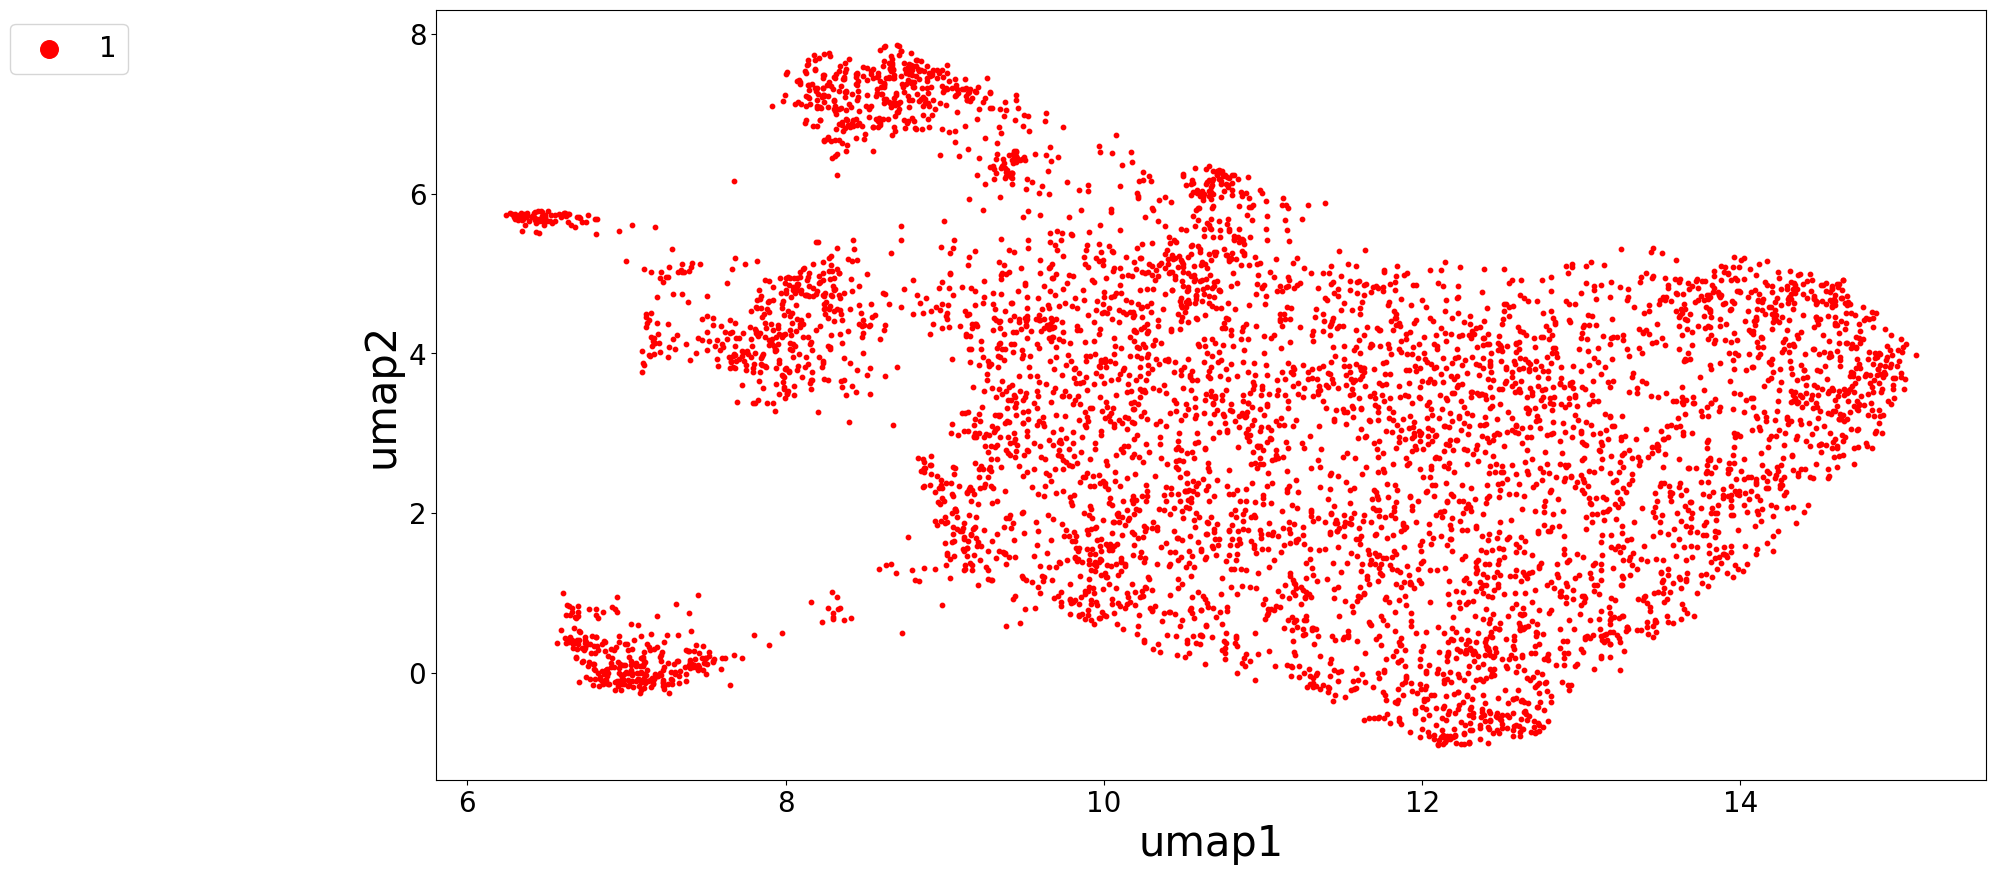

In [29]:
batch=SPII.meta.loc[:,'batch']
ub=np.unique(batch)
import umap.umap_ as umap
import matplotlib.pyplot as plt
umap_mat=umap.UMAP().fit_transform(embed)
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(20,10))
size=10
for i in range(len(ub)):
    axs.scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour2[i],s=size)

axs.set_xlabel("umap1",fontsize=30)
axs.set_ylabel("umap2",fontsize=30)
axs.legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)


R code to be run after this step.


In [32]:
import anndata
import scanpy as sc
adata=anndata.AnnData(SPII.feat)
adata.obsm['spiral']=embed1.values
adata.obs['batch']=SPII.meta.loc[:,'batch'].values
cluster_file = '/_1_seuratmethod_clust_modify3.csv'
coord=pd.read_csv(coord_file[0],header=0,index_col=0)
for i in np.arange(1,len(samples)):
    coord=pd.concat((coord,pd.read_csv(coord_file[i],header=0,index_col=0)))

adata.obsm['spatial']=coord.loc[adata.obs_names,:].values
cluster=pd.read_csv(cluster_file,header=0,index_col=0)
adata.obs['SPIRAL']=cluster.loc[adata.obs_names,:]

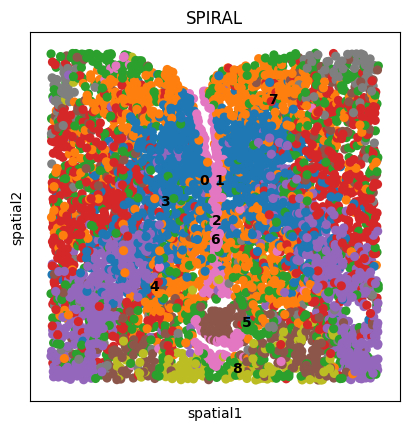

In [33]:
adata.obs['SPIRAL']=adata.obs['SPIRAL'].astype('category')
size1=50
metric='SPIRAL'
sc.pl.spatial(adata,color=metric, spot_size=size1,legend_loc='on data')